In [18]:
import os

import copy
import random
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd 

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc #, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import load_img

import scipy.stats as st
from scipy.stats import norm
from tabulate import tabulate

from logging_utils import *
from logging_utils import myLogger, print_log, close_loggers 

from plot_utils import plot_mean_ROC, plot_mean_PR
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [13]:
SEED = 1970
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

color_index = list(mcolors.CSS4_COLORS)
colors = mcolors.CSS4_COLORS

data_path = './data/'
mean_metrics = 'mean_metrics.csv'
mean_metrics_VA = 'mean_metrics_231231.csv'

mean_metrics_cols = ['date', 'model', 'image_size', 'batch_size', 'channel', 'test_set','roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metrics_cols = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metric_name = ['ROC AUC', 'PR AUC', 'F1', 'Precision', 'Recall']
test_label = ['test_loc', 'test_NoL']
test_classes = {'test_loc' : [5812, 336], 'test_NoL' : [3742, 835]}

# channel_label = ['RGB', '3', 'EI', 'MI', '5']
channel_label = ['RGB', 'HSV', 'EI', 'MI', '5']
channel_label_alt = ['RGB', 'HSV', 'HSV + EI', 'HSV + MI', 'HSV + EI + MI']

test_no_lesion_id_image_folder_path = "./jpeg/231115_all_data_ISIC/512/" 
test_image_folder_path = "./jpeg/231115_all_data_ISIC/512/" 

In [4]:
df_test = pd.read_csv(data_path + '231120_test.csv')                            # 15% of all available ISIC data
df_test_no_lesion_id = pd.read_csv(data_path + '231120_no_lesion_ID.csv')       # additional local test set of data with no patient_id and no lesion_id, subset of full ISIC dataset


In [5]:
df_test.head()

isic_id attribution copyright_license  acquisition_day  age_approx  \
0  ISIC_0011405   Anonymous              CC-0              NaN        65.0   
1  ISIC_0011406   Anonymous              CC-0              NaN        20.0   
2  ISIC_0011424   Anonymous              CC-0              NaN        85.0   
3  ISIC_0011425   Anonymous              CC-0              NaN        85.0   
4  ISIC_0011429   Anonymous              CC-0              NaN        60.0   

  anatom_site_general benign_malignant  clin_size_long_diam_mm  \
0           head/neck        malignant                     NaN   
1           head/neck           benign                     NaN   
2     upper extremity           benign                     NaN   
3     upper extremity           benign                     NaN   
4     upper extremity        malignant                     NaN   

        dermoscopic_type diagnosis  ... mel_mitotic_index mel_thick_mm  \
0  contact non-polarized  melanoma  ...               NaN          NaN   
1  contact non-polarized     nevus  ...               NaN          NaN   
2  contact non-polarized       NaN  ...               NaN          NaN   
3  contact non-polarized       NaN  ...               NaN          NaN   
4  contact non-polarized  melanoma  ...               NaN          NaN   

  mel_type mel_ulcer melanocytic nevus_type  patient_id personal_hx_mm  \
0      NaN       NaN        True        NaN  IP_8355925            NaN   
1      NaN       NaN        True        NaN  IP_6424174            NaN   
2      NaN       NaN         NaN        NaN  IP_1857100            NaN   
3      NaN       NaN         NaN        NaN  IP_1857100            NaN   
4      NaN       NaN        True        NaN  IP_3406334            NaN   

      sex target  
0    male   True  
1  female  False  
2  female  False  
3  female  False  
4  female   True  

[5 rows x 25 columns]

In [42]:
def show_grid_images(df, N_rows = 7, N_cols = 7, title = 'Randomly selected images from the local test set (15% of all data)'):
    print(f'{title}')
    pick_I = [random.randint(0, df_test.shape[0]) for i in range(N_rows * N_cols)]
    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(12)

    for r in range(N_rows):
        for c in range(N_cols):
            t_image = df_test.iloc[pick_I[r * N_cols + c]]
            test_image = t_image.isic_id
            if t_image.target:
                t_target = 'Malignant' 
            else: 
                t_target = 'Benign'
            ax = fig.add_subplot(N_rows, N_cols, r * N_cols + c + 1)
            img = load_img(test_image_folder_path + test_image + '.jpg')
            imgplot = plt.imshow(img)
            ax.set_title(t_target)
            plt.axis('off')
    # plt.title('Randomly selected images from the local test set (15% of all data)')
    plt.plot()

Randomly selected images from the local test set (15% of all data)


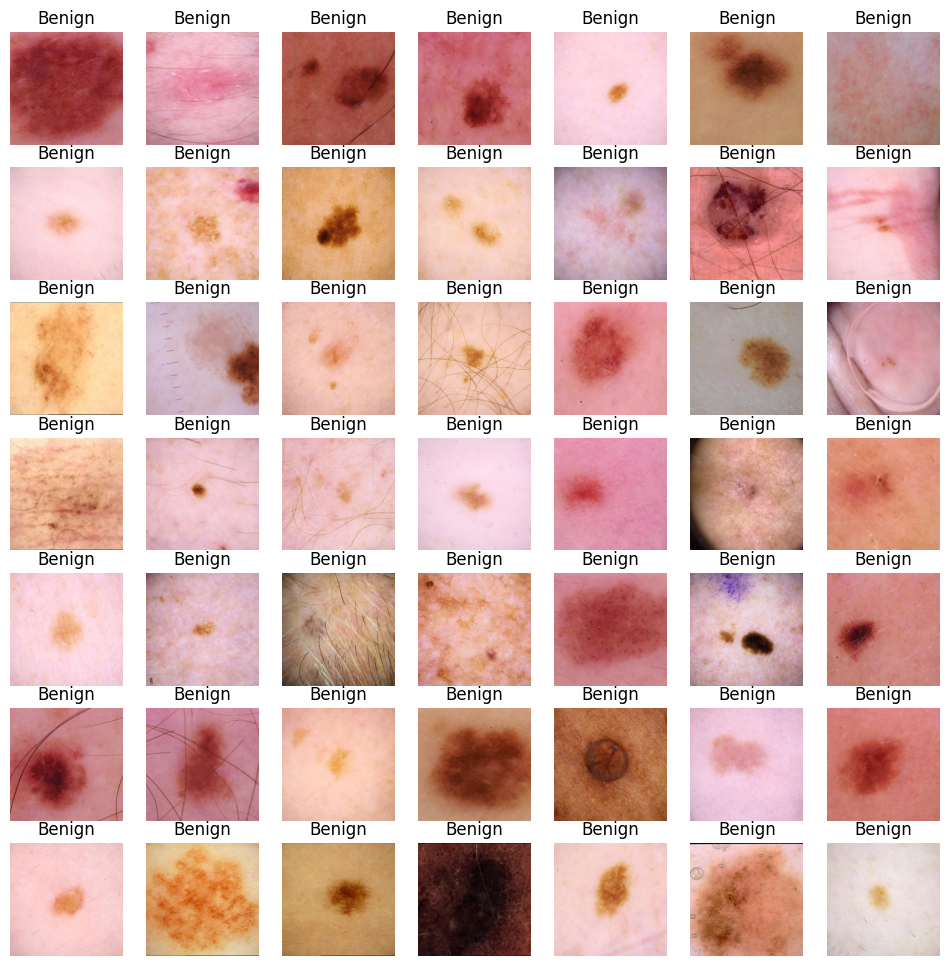

In [43]:
show_grid_images(df_test, N_rows = 7, N_cols = 7, title = 'Randomly selected images from the local test set (15% of all data)')

Randomly selected images from the local test set (15% of all data)


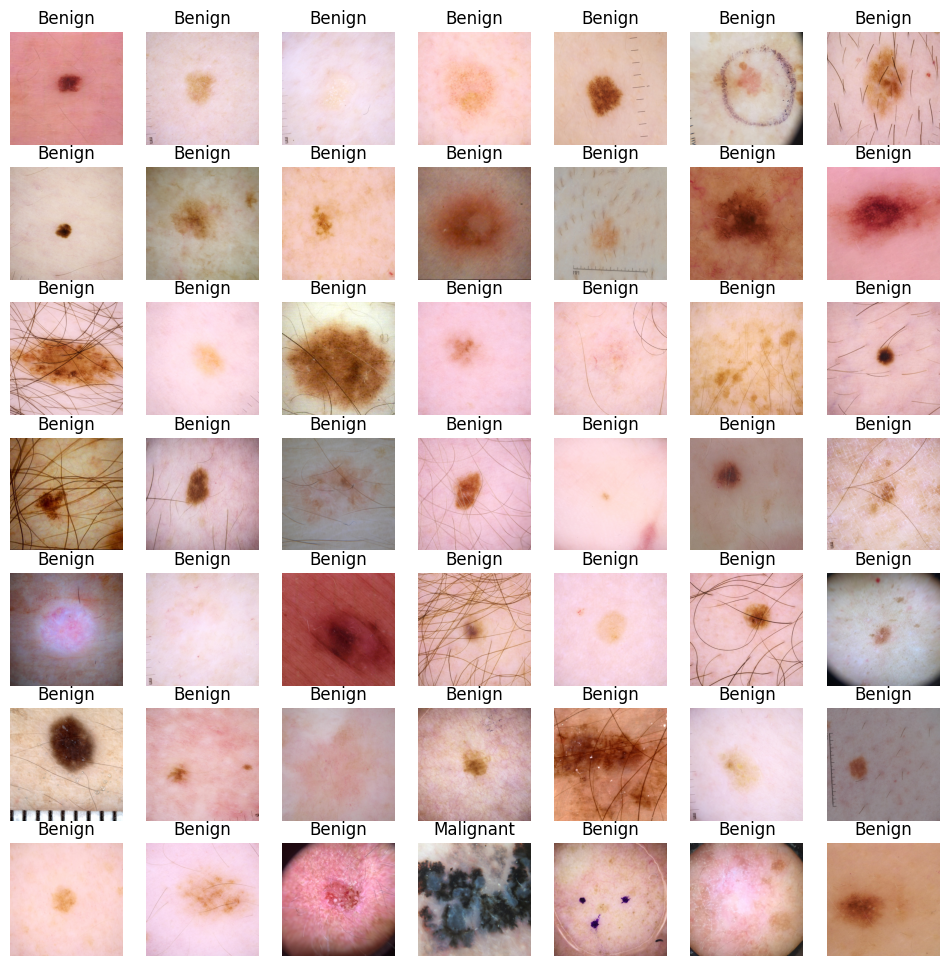

In [44]:
show_grid_images(df_test_no_lesion_id, N_rows = 7, N_cols = 7, title = 'Randomly selected images from the test set (15% of all data)')

In [103]:
def normalize_color(img):
    new_image = np.ones(np.array(img).shape).astype(int)
    npsum = np.array(img).sum(axis = 2)
    new_image[:, :, 0] = (np.array(img)[:, :, 0] / npsum * 255).astype('int')
    new_image[:, :, 1] = (np.array(img)[:, :, 1] / npsum * 255).astype('int')
    new_image[:, :, 2] = (np.array(img)[:, :, 2] / npsum * 255).astype('int')
    return new_image

In [191]:
df_test.loc[df_test.isic_id == 'ISIC_3031937'].isic_id.values[0]

'ISIC_3031937'

In [184]:
tt = test_image_folder_path +  + '.jpg'
tt

'./jpeg/231115_all_data_ISIC/512/2421    ISIC_3031937\nName: isic_id, dtype: object.jpg'

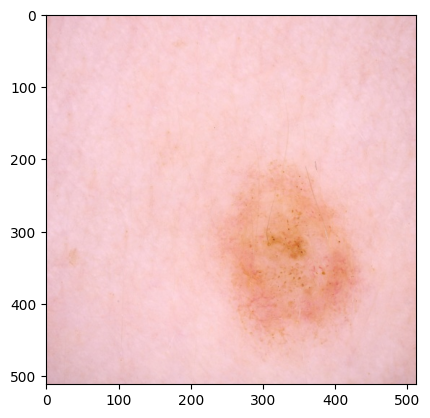

In [196]:
img = load_img(str(test_image_folder_path + df_test.loc[df_test.isic_id == 'ISIC_3031937']['isic_id'].values[0] + '.jpg'))
plt.imshow(img)

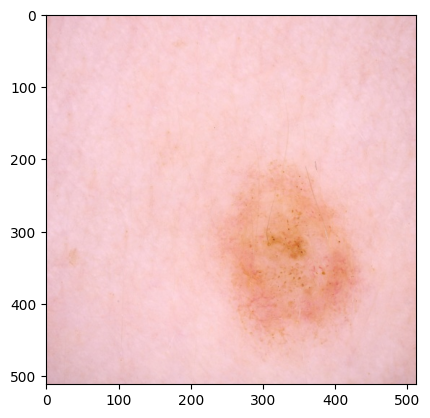

In [205]:
plt.imshow(fit_skin(img))

In [197]:
np_img = np.array(img).astype(int)

In [198]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

167 80 26
255 218 229


In [199]:
if red_min < 95:
    np_img[:, :, 0] = np_img[:, :, 0] + 95 - red_min
if green_min < 40:
    np_img[:, :, 1] = np_img[:, :, 1] + 40 - green_min
if blue_min < 20:
    np_img[:, :, 2] = np_img[:, :, 2] + 20 - blue_min

In [200]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

167 80 26
255 218 229


In [201]:
np_img[:, :, 0] = np.where(np_img[:, :, 0] > np_img[:, :, 2], np_img[:, :, 0], np_img[:, :, 2] + 1)
np_img[:, :, 0] = np.where(np_img[:, :, 0] > np_img[:, :, 1] + 15, np_img[:, :, 0], np_img[:, :, 1] + 15)
np_img[:, :, 0]

array([[227, 226, 226, ..., 231, 231, 231],
       [227, 226, 226, ..., 231, 231, 231],
       [227, 226, 227, ..., 229, 229, 230],
       ...,
       [209, 209, 210, ..., 214, 212, 212],
       [210, 210, 211, ..., 212, 212, 212],
       [209, 209, 209, ..., 213, 214, 215]])

In [202]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

167 80 26
255 218 229


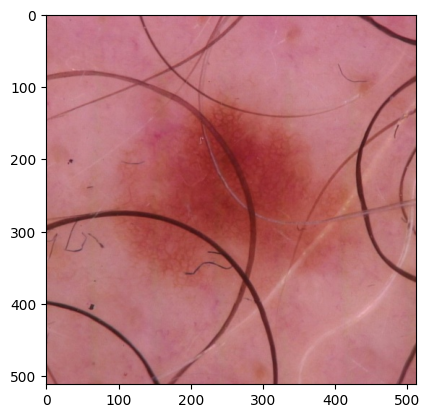

In [55]:
img = load_img(test_image_folder_path + df_test.iloc[4000].isic_id + '.jpg')
plt.imshow(img)

In [133]:
np_img = np.array(img).astype(int)

In [134]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

60 16 13
237 177 183


In [135]:
if red_min < 95:
    np_img[:, :, 0] = np_img[:, :, 0] + 95 - red_min
if green_min < 40:
    np_img[:, :, 1] = np_img[:, :, 1] + 40 - green_min
if blue_min < 20:
    np_img[:, :, 2] = np_img[:, :, 2] + 20 - blue_min
    

In [136]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

95 40 20
272 201 190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


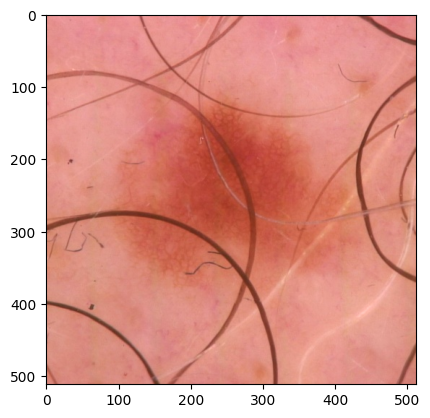

In [137]:
plt.imshow(np_img)

In [141]:
np_img[:, :, 0] = np.where(np_img[:, :, 0] > np_img[:, :, 2], np_img[:, :, 0], np_img[:, :, 2] + 1)
np_img[:, :, 0] = np.where(np_img[:, :, 0] > np_img[:, :, 1] + 15, np_img[:, :, 0], np_img[:, :, 1] + 15)
np_img[:, :, 0]

array([[235, 232, 228, ..., 226, 227, 223],
       [235, 235, 232, ..., 229, 230, 226],
       [233, 235, 234, ..., 229, 231, 228],
       ...,
       [216, 217, 219, ..., 210, 209, 207],
       [215, 216, 217, ..., 209, 208, 209],
       [215, 217, 217, ..., 210, 209, 211]])

In [211]:
def fit_skin(img):
    np_img = np.array(img).astype(int)
    red_min = np_img[:, :, 0].min()
    green_min = np_img[:, :, 1].min()
    blue_min = np_img[:, :, 2].min()
    
    if red_min < 95:
        np_img[:, :, 0] = np_img[:, :, 0] + 95 - red_min
    if green_min < 40:
        np_img[:, :, 1] = np_img[:, :, 1] + 40 - green_min
    if blue_min < 20:
        np_img[:, :, 2] = np_img[:, :, 2] + 20 - blue_min

    np_img[:, :, 0] = np.where(np_img[:, :, 0] > np_img[:, :, 2], np_img[:, :, 0], np_img[:, :, 2] + 1)
    np_img[:, :, 0] = np.where(np_img[:, :, 0] > np_img[:, :, 1] + 15, np_img[:, :, 0], np_img[:, :, 1] + 15)    

    red_max = np_img[:, :, 0].max()
    green_max = np_img[:, :, 1].max()
    blue_max = np_img[:, :, 2].max()

    if red_max > 255:
        np_img[:, :, 0] = (np_img[:, :, 0]/red_max * 255).astype(int)
    if green_max > 255:
        np_img[:, :, 1] = (np_img[:, :, 1]/green_max * 255).astype(int)
    if blue_max > 255:
        np_img[:, :, 2] = (np_img[:, :, 2]/blue_max * 255).astype(int)
        
    print(red_max, green_max, blue_max)
    
    return np_img

In [142]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

95 40 20
272 201 190


In [143]:
np_img[:, :, 0] = (np_img[:, :, 0]/red_max * 255).astype(int)

In [144]:
red_min = np_img[:, :, 0].min()
green_min = np_img[:, :, 1].min()
blue_min = np_img[:, :, 2].min()

red_max = np_img[:, :, 0].max()
green_max = np_img[:, :, 1].max()
blue_max = np_img[:, :, 2].max()

print(red_min, green_min, blue_min)
print(red_max, green_max, blue_max)

89 40 20
255 201 190


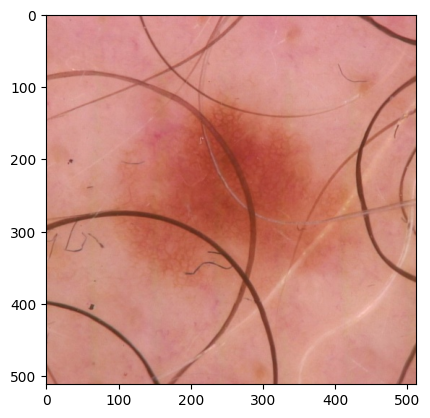

In [145]:
plt.imshow(np_img)

In [59]:
npsum = np.array(img).sum(axis = 2)
print(np.array(img).shape)
print(np.array(npsum).shape)

(512, 512, 3)
(512, 512)


In [60]:
npsum

array([[468, 459, 450, ..., 429, 432, 420],
       [468, 468, 462, ..., 437, 441, 428],
       [462, 468, 465, ..., 439, 446, 436],
       ...,
       [405, 408, 416, ..., 389, 386, 380],
       [400, 403, 410, ..., 386, 383, 386],
       [400, 406, 410, ..., 389, 386, 392]], dtype=uint32)

In [100]:
new_image = np.ones(np.array(img).shape).astype(int)
new_image.shape

(512, 512, 3)

In [97]:
new_image[:, :, 0] = (np.array(img)[:, :, 0] / npsum * 255).astype('int')
new_image[:, :, 1] = (np.array(img)[:, :, 1] / npsum * 255).astype('int')
new_image[:, :, 2] = (np.array(img)[:, :, 2] / npsum * 255).astype('int')

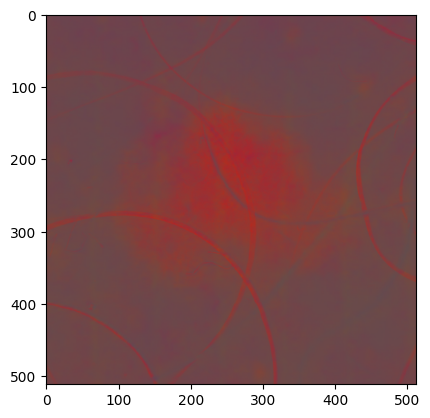

In [105]:
plt.imshow(normalize_color(img))

In [176]:

def show_grid_images_2(df, N_rows = 5, N_cols = 4, title = 'Randomly selected images from the local test set (15% of all data)'):
    print(f'{title}')
    pick_I = [random.randint(0, df_test.shape[0]) for i in range(N_rows * N_cols)]
    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(12)

    for r in range(N_rows):
        for c in range(N_cols):
            t_image = df_test.iloc[pick_I[r * N_cols + c]]
            test_image = t_image.isic_id
            if t_image.target:
                t_target = 'Malignant' 
            else: 
                t_target = 'Benign'
            ax = fig.add_subplot(N_rows, N_cols * 2, r  * N_cols * 2 + c * 2 + 1)
            img = load_img(test_image_folder_path + test_image + '.jpg')
            imgplot = plt.imshow(img)
            ax.set_title(t_target)
            plt.axis('off')

            ax = fig.add_subplot(N_rows, N_cols * 2, r * N_cols * 2 + 1 + c * 2 + 1)
            norm_img = fit_skin(img)
#             norm_img = normalize_color(img)
            imgplot = plt.imshow(norm_img)
            ax.set_title(test_image)
            plt.axis('off')
    plt.plot()

Randomly selected images from the local test set (15% of all data)
255 193 184
344 262 218
293 221 179
255 233 250
255 226 250
242 202 187
302 236 232
255 216 235
310 276 270
255 219 244
286 228 177
248 204 203
247 205 198
286 208 198
261 193 251
316 263 239
255 239 242
331 277 261
254 218 231
255 226 242
308 272 258
255 221 225
294 256 255
255 224 232
255 214 224
255 224 223
270 255 255
255 214 192


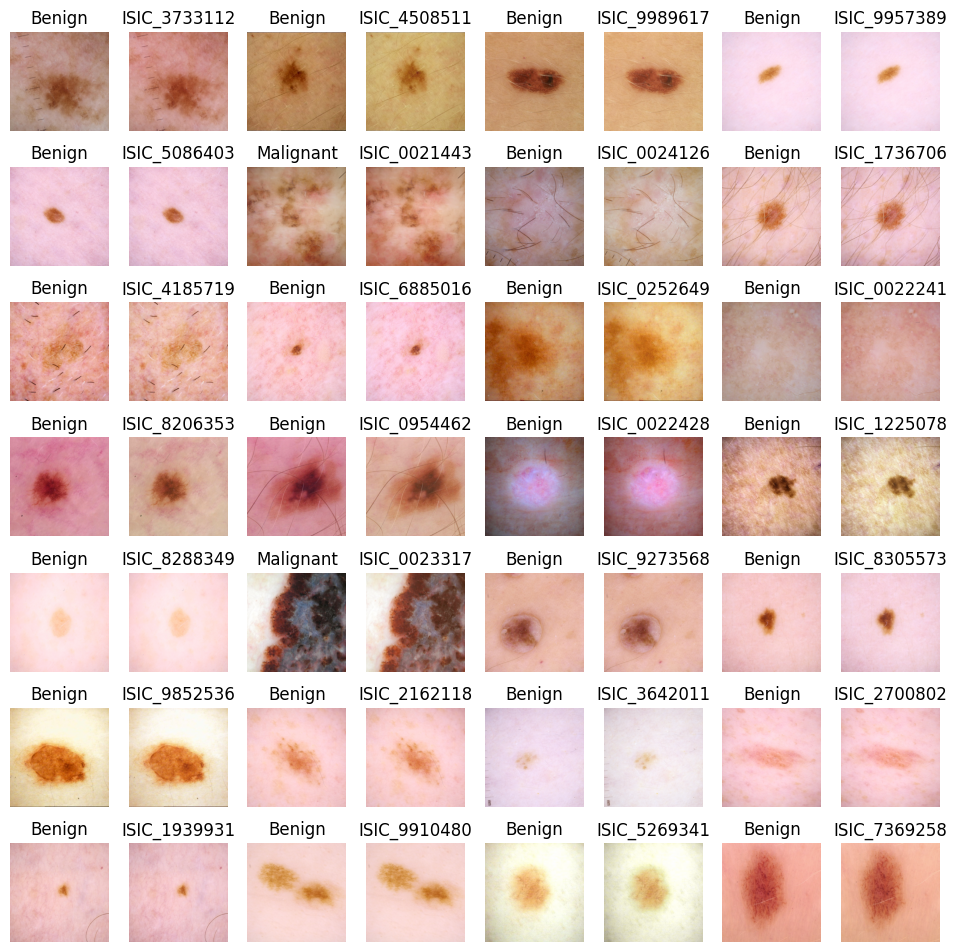

In [213]:
show_grid_images_2(df_test, N_rows = 7, N_cols = 4, title = 'Randomly selected images from the local test set (15% of all data)')

Randomly selected images from the local test set (15% of all data)
255 225 235
350 292 274
342 279 244
206 150 128
252 192 189
218 157 143
255 222 247
275 236 247
301 247 252
255 223 226
350 292 275
228 213 222
260 206 197
255 233 252
339 265 231
255 222 233
314 265 246
256 201 185
350 290 268
255 218 230


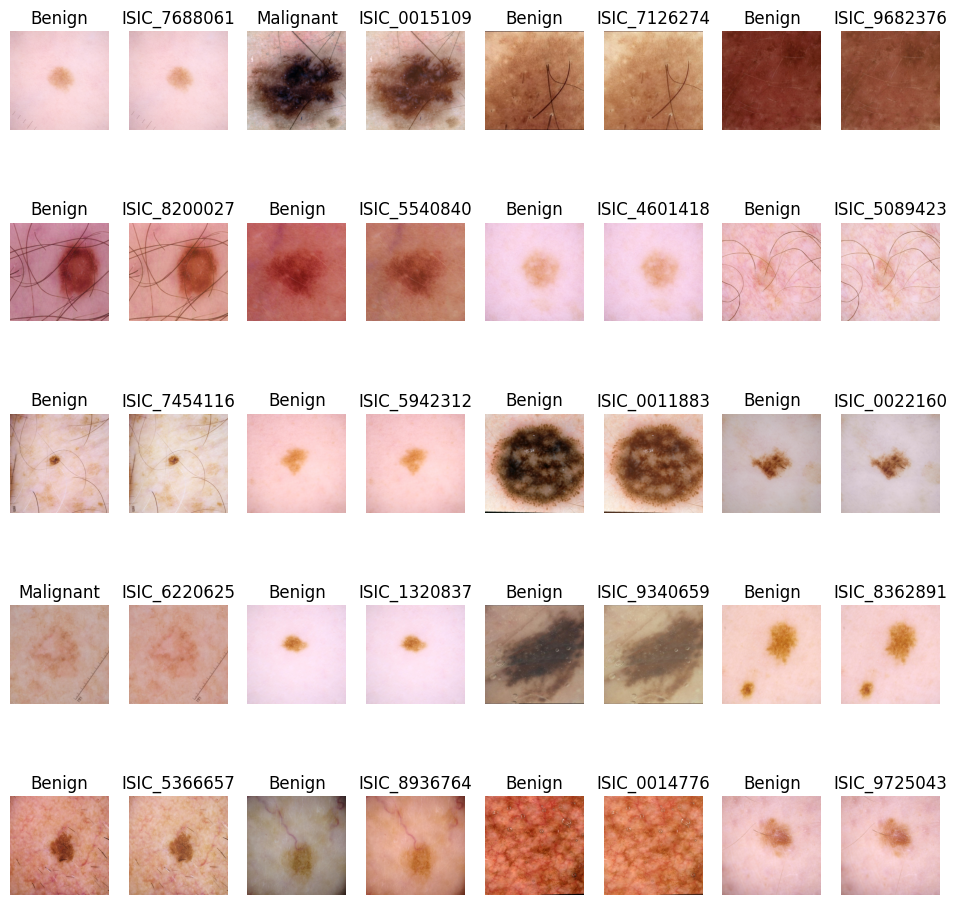

In [212]:
show_grid_images_2(df_test, N_rows = 5, N_cols = 4, title = 'Randomly selected images from the local test set (15% of all data)')